In [1]:
# escludi da 16 a 27
import pandas as pd
import matplotlib.pyplot as plt
#!pip install squarify
import squarify
import numpy as np
import matplotlib

import geopandas as gpd
import os

import seaborn as sns

from collections import Counter
import re 

import holoviews as hv


font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

def job(x):
    if type(x)==str:
        x = x.lower().split(",")[0].strip() # primary occupation
        if x in ['psichiatra','medico specializzando','neuropsichiatra infantile','medico igienista','neurologo']:
            x = 'Clinician'
        elif x in ['psicoterapeuta','psicologo/a','consulente legale']:
            x = 'Psychologist'
        elif x in ['dietista', 'infermiere/a specializzato/a','neuropsichiatra infantile','tnpee','tecnico/a della riabilitazione psichiatrica','educatrice di centro sociale','educatore','educatore professionale','assistente sanitaria']:
            x = 'Other'
    return x


surv = pd.read_csv("survey_ita.tsv",sep="\t").iloc[3:,3:].reset_index(drop=True)
surv2 = pd.read_csv("survey_ita_2.tsv",sep="\t").iloc[:,2:]
surv = pd.concat([surv, surv2],ignore_index=True)
surv.iloc[:,4] = surv.iloc[:,4].apply(job)
surv.head(3)

,Età,Genere,Regione di appartenenza della struttura sanitaria in cui opera,Tipologia della struttura sanitaria,Ruolo professionale (è possibile indicare più di 1 risposta),Le sue prestazioni sanitarie hanno subito un calo durante l'emergenza?,"Se ha risposto sì, qual è stata la motivazione principale del calo?","Se ha risposto sì, quantifichi l'impatto dell'emergenza sulla sua attività lavorativa:",Con quali modalità ha erogato le sue prestazioni DURANTE l'emergenza?,La Regione di appartenenza della struttura in cui opera dispone del registro clinico elettronico?,...,Indichi per quali delle seguenti prestazioni utilizzava gli strumenti telematici indicati PRIMA dell'emergenza [Valutazione/Monitoraggio di pazienti di nuovo esordio].1,Indichi per quali delle seguenti prestazioni utilizzava gli strumenti telematici indicati PRIMA dell'emergenza [Gestione dell'emergenza].1,Indichi per quali delle seguenti prestazioni utilizzava gli strumenti telematici indicati PRIMA dell'emergenza [Monitoraggio della terapia farmacologica].1,Indichi per quali delle seguenti prestazioni utilizzava gli strumenti telematici indicati PRIMA dell'emergenza [Prescrizione di farmaci].1,Indichi per quali delle seguenti prestazioni utilizzava gli strumenti telematici indicati PRIMA dell'emergenza [Psicoterapia live].1,Indichi per quali delle seguenti prestazioni utilizzava gli strumenti telematici indicati PRIMA dell'emergenza [Psicoterapia tramite trasferimento di materiale audio-visivo].1,Indichi per quali delle seguenti prestazioni utilizzava gli strumenti telematici indicati PRIMA dell'emergenza [Riabilitazione psichiatrica].1,Indichi per quali delle seguenti prestazioni utilizzava gli strumenti telematici indicati PRIMA dell'emergenza [Consulenza giuridica in ambito civile].1,Indichi per quali delle seguenti prestazioni utilizzava gli strumenti telematici indicati PRIMA dell'emergenza [Consulenza giuridica in ambito penale].1,L'impiego di strumenti telematici per la salute mentale permette di abbattere la barriera dello stigma
0,31 - 40,Maschile,Veneto,Azienda Sanitaria Locale,Clinician,No,NaN,NaN,"Mista, prevalentemente in presenza",Sì,...,NaN,"Telefono (chiamate, SMS), e-mail","Telefono (chiamate, SMS)",NaN,NaN,NaN,NaN,NaN,NaN,3.0
1,31 - 40,Maschile,Campania,Azienda Ospedaliera,Clinician,Sì,Lockdown,6,"Mista, prevalentemente in presenza",No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,31 - 40,Maschile,Toscana,Azienda Ospedaliera,Clinician,Sì,Interruzione di servizi non urgenti,7,"Mista, prevalentemente tramite strumenti telem...",Sì,...,"Telefono (chiamate, SMS)","Telefono (chiamate, SMS)","Telefono (chiamate, SMS)","Telefono (chiamate, SMS), Piattaforma certific...",NaN,NaN,NaN,NaN,NaN,2.0


Se ha risposto sì, quantifichi l'impatto dell'emergenza sulla sua attività lavorativa:


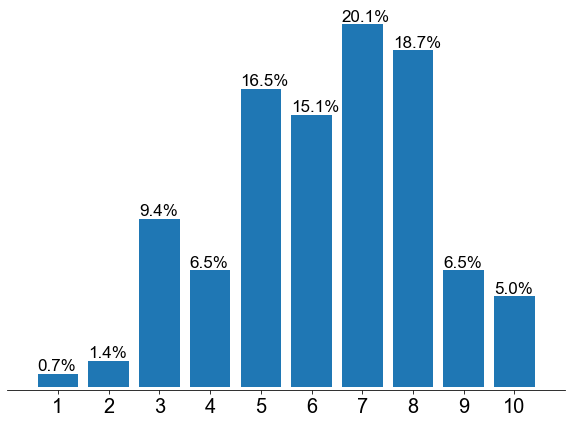

In [3]:

print(surv.columns[7])

temp = surv[surv.columns[7]].dropna().astype(int).value_counts()
temp = 100 *(temp / temp.sum()) 
temp = temp.sort_index()
fig,ax = plt.subplots(figsize=(10,7))
ax.bar(temp.index, temp.values, align='center')

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 3))
ax.set_xlim(0,11)
ax.set_xbound(0,11)
ax.set_xticks((1,2,3,4,5,6,7,8,9,10))
ax.set_yticks(())

for i,(l,n) in enumerate(temp.items()):
    if  n>=10:
        plt.text(x = i+.6 , y = n+.2 , s = str(round(n,1))+'%' , size = 17, color="black")
    else:
        plt.text(x = i+.6 , y = n+.2 , s = str(round(n,1))+'%' , size = 17, color="black")
        
#fig.savefig(os.getcwd() + "\\figures\\figure_2\\practice_affected.tiff",dpi=600, bbox_inches = "tight")

Con quali modalità ha erogato le sue prestazioni DURANTE l'emergenza?
Con quali modalità erogava le sue prestazioni PRIMA dell'emergenza?


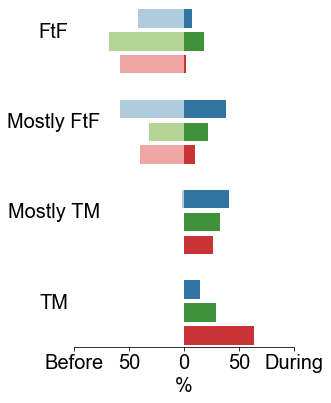

In [4]:

print(surv.columns[8])
print(surv.columns[47])

def mode_work(x):
    if type(x)==str:
        x = x
        if x in ["Esclusivamente in remoto, tramite strumenti telematici"]:
            x = 'TM'
        elif x in ["Mista, prevalentemente tramite strumenti telematici"]:
            x = 'Mostly TM'
        elif x in ["Mista, prevalentemente in presenza"]:
            x = 'Mostly FtF'
        elif x in ["Esclusivamente in presenza"]:
            x = 'FtF'
    return x

modal = surv.iloc[:,[4,47,8]]
modal = modal.rename(columns={"Ruolo professionale (è possibile indicare più di 1 risposta)":"role","Con quali modalità erogava le sue prestazioni PRIMA dell'emergenza?":"before","Con quali modalità ha erogato le sue prestazioni DURANTE l'emergenza?":"during"})
modal = modal.dropna().reset_index(drop=True)
modal = modal.apply(job)
modal["before"] = modal["before"].apply(mode_work)
modal["during"] = modal["during"].apply(mode_work)

before = modal.iloc[:,[0,1]].groupby(["role","before"]).size().reset_index()
before["when"] = "before"
before = before.rename(columns={"before":"perc",0:"value"})
before["value"] = 100 * (before["value"]/before["value"].sum())

during = modal.iloc[:,[0,2]].groupby(["role","during"]).size().reset_index()
during["when"] = "during"
during=during.rename(columns={"during":"perc",0:"value"})
during["value"] = 100 * (during["value"]/during["value"].sum())

alt = pd.concat([before,during])

bef = alt["when"]=="before"
dur = alt["when"]=="during"

for r in alt["role"].unique():
    rl = alt["role"]==r
    alt.loc[bef & rl,"value"]= -100 * ( alt.loc[bef & rl,"value"] / alt.loc[bef & rl,"value"].sum())    
    alt.loc[dur & rl,"value"]= 100 * ( alt.loc[dur & rl,"value"] / alt.loc[dur & rl,"value"].sum())    
    
percs = ['TM', 'Mostly TM', 'Mostly FtF', 'FtF']
percs.reverse()

fig,axs = plt.subplots(len(percs),1,figsize=(5,6))

for j,ax in enumerate(axs):
    temp = alt[alt["perc"]==percs[j]]
    when_c = dict(before=['#a6cee3','#b2df8a','#fb9a99'],during=['#1f78b4','#33a02c','#e31a1c'])
    for i,w in enumerate(["before","during"]):
        if np.any(temp[temp["when"]==w]):
            when = temp[temp["when"]==w]
        else:
            when["value"]=0
            
        sns.barplot(ax = ax, data=when,x="value",y="role",palette=when_c[w])
        ax.set_ylabel(percs[j],rotation=0,labelpad=20)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False) 
        ax.set_xlim(-100,100)
        ax.set_yticks([])
        if j!=len(percs)-1:
            ax.spines['bottom'].set_visible(False)
            ax.set_xlabel("")
            ax.set_xticklabels([])
            ax.set_xticks([])
        else:
            ax.set_xlabel("%")
            ax.set_xticks((-100,-50,0,50,100))
            
            ax.set_xticklabels(["Before","50","0","50","During"])
    ax.set_yticklabels([])
plt.tight_layout()

#fig.savefig(os.getcwd() + "\\figures\\figure_2\\prov_MH.tiff",dpi=600, bbox_inches = "tight")

Quale percentuale delle sue prestazioni ha erogato tramite strumenti telematici DURANTE l'emergenza?
Quale percentuale delle sue prestazioni erogava tramite strumenti telematici PRIMA dell'emergenza ?


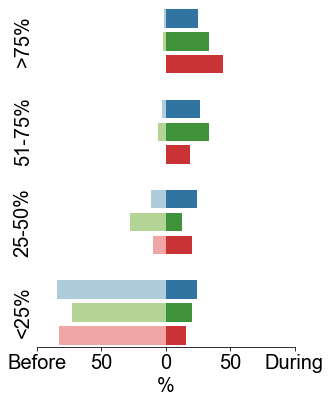

In [5]:

print(surv.columns[12])
print(surv.columns[28])

durante = surv[surv.columns[[4,12]]].dropna().reset_index(drop=True).copy()
prima = surv[surv.columns[[4,28]]].dropna().reset_index(drop=True).copy()
durante.columns=["role","perc"]
prima.columns=["role","perc"]
durante.iloc[:,0] = durante.iloc[:,0].apply(job)
prima.iloc[:,0] = prima.iloc[:,0].apply(job)

def perce(x):
    x=x.lower()

    if x in ["meno del 25%"]:
        x = "<25%"
    elif x in ["oltre il 75%"]:
        x = ">75%"
    return x

durante.iloc[:,1] = durante.iloc[:,1].apply(perce)
prima.iloc[:,1] = prima.iloc[:,1].apply(perce)

prima = prima.groupby(["role","perc"]).size().reset_index()
prima["when"] = "before"
durante = durante.groupby(["role","perc"]).size().reset_index()
durante["when"] = "during"

alt = pd.concat([prima,durante])
alt = alt.rename(columns={0:"value"})

bef = alt["when"]=="before"
dur = alt["when"]=="during"

for r in alt["role"].unique():
    rl = alt["role"]==r
    alt.loc[bef & rl,"value"]= -100 * ( alt.loc[bef & rl,"value"] / alt.loc[bef & rl,"value"].sum())    
    alt.loc[dur & rl,"value"]= 100 * ( alt.loc[dur & rl,"value"] / alt.loc[dur & rl,"value"].sum())    
    
percs = ['<25%', '25-50%', '51-75%', '>75%']
percs.reverse()

fig,axs = plt.subplots(len(percs),1,figsize=(5,6))

for j,ax in enumerate(axs):
    temp = alt[alt["perc"]==percs[j]]
    when_c = dict(before=['#a6cee3','#b2df8a','#fb9a99'],during=['#1f78b4','#33a02c','#e31a1c'])
    for i,w in enumerate(["before","during"]):
        when = temp[temp["when"]==w]
        sns.barplot(ax = ax, data=when,x="value",y="role",palette=when_c[w])
        ax.set_ylabel(percs[j])
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False) 
        ax.set_xlim(-100,100)
        ax.set_yticks([])
        if j!=len(percs)-1:
            ax.spines['bottom'].set_visible(False)
            ax.set_xlabel("")
            ax.set_xticklabels([])
            ax.set_xticks([])
        else:
            ax.set_xlabel("%")
            ax.set_xticks((-100,-50,0,50,100))
            
            ax.set_xticklabels(["Before","50","0","50","During"])
    ax.set_yticklabels([])
plt.tight_layout()

#fig.savefig(os.getcwd() + "\\figures\\figure_2\\TM_MH.tiff",dpi=600, bbox_inches = "tight")

Quali tra i seguenti strumenti telematici ha utilizzato DURANTE l'emergenza per raggiungere e fornire supporto ai pazienti?
Quali tra i seguenti strumenti telematici utilizzava PRIMA dell'emergenza per raggiungere e fornire supporto ai pazienti?


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
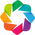

:Sankey   [when,tool]   (value)

In [6]:

def tool(x):
    x=x

    if x in ['Telefono (chiamate, SMS)']:
        x = "Phone"
    elif x in ['Videoconferenza (Skype, Zoom etc)']:
        x = "VTC"
    elif x in ['Chat (Whatsapp, Telegram etc)']:
        x = "IM"
    elif x in ['e-mail']:
        x = 'e-Mail'
    elif x in ['Piattaforma certificata di telemedicina']:
        x = 'STM'
    elif x in ['Registro clinico elettronico']:
        x = 'EHR'
        
    return x
    

print(surv.columns[10])
print(surv.columns[15])

during = surv[surv.columns[10]].dropna().reset_index(drop=True).copy()
before = surv[surv.columns[15]].dropna().reset_index(drop=True).copy()

r = re.compile(r'(?:[^,(]|\([^)]*\))+')
during = [tool(s.strip()) for dur in during for s in r.findall(dur)]
before = [tool(s.strip()) for dur in before for s in r.findall(dur)]


during = pd.DataFrame( Counter(during).items() )
during = during.rename(columns={0:"tool",1:"value"})
during["value"] = 100*(during["value"]/during["value"].sum())
during["when"]="during"

before = pd.DataFrame( Counter(before).items() )
before = before.rename(columns={0:"tool",1:"value"})
before["value"] = 100*(before["value"]/before["value"].sum())
before["when"]="before"


hv.extension('bokeh')


alt = pd.concat([before,during]).reset_index(drop=True).sort_values(by="tool")

sankey1 = hv.Sankey(alt, kdims=["when","tool"], vdims=["value"])

sankey1.opts(cmap='Colorblind',label_position='outer',
                                 edge_color='tool', edge_line_width=0,
                                 node_alpha=1.0, node_width=40, node_sort=True,
                                 width=1000, height=800, bgcolor="white",toolbar=None)

#hv.save(sankey1,os.getcwd() + '\\figures\\figure_2\\tools.png', backend='bokeh')

sankey1

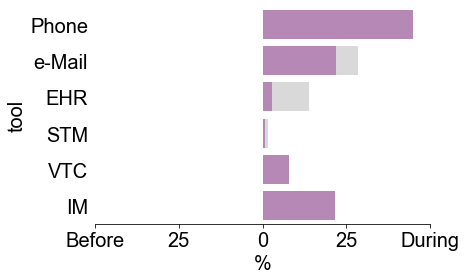

In [7]:
fig, ax = plt.subplots()

sns.barplot( y='tool', x='value', data=during, color="#d9d9d9",ci=None)

sns.barplot( y='tool', x='value', data=before, color='#bc80bd',ci=None)

ax.set_xlim(-50,50)
#ax.set_ylabel(role[i])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False) #axis="y",which="minor")

ax.set_xlabel("%")
ax.set_xticks((-50,-25,0,25,50))
ax.set_xticklabels(["Before","25","0","25","During"])
#ax.set_yticks((0,1,2,3,4,5))
#ax.set_yticklabels([5,4,3,2,1,])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    labelleft=True) # labels along the bottom edge are off

#fig.savefig(os.getcwd() + "\\figures\\figure_2\\TP_useful.tiff",dpi=600, bbox_inches = "tight")

Quanto ritiene che gli strumenti telematici le siano stati utili DURANTE l'emergenza per raggiungere e fornire supporto soddisfacente ai pazienti?
PRIMA dell'emergenza, quanto riteneva utili gli strumenti telematici per raggiungere e fornire supporto soddisfacente ai pazienti ?


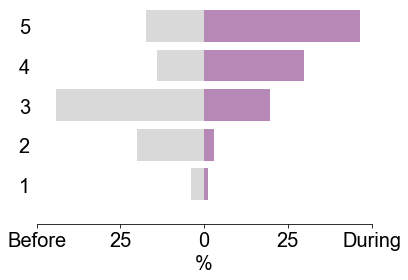

In [8]:

print(surv.columns[13])
print(surv.columns[29])


during = surv[surv.columns[13]].dropna().reset_index(drop=True).copy()
before = surv[surv.columns[29]].dropna().reset_index(drop=True).copy()

before = pd.DataFrame(before.value_counts().sort_index()).reset_index()
before = before.rename(columns={"index":"judge","PRIMA dell'emergenza, quanto riteneva utili gli strumenti telematici per raggiungere e fornire supporto soddisfacente ai pazienti ?":"value"})
before.value = -100*(before.value/before.value.sum())

during = pd.DataFrame(during.value_counts().sort_index()).reset_index()
during = during.rename(columns={"index":"judge","Quanto ritiene che gli strumenti telematici le siano stati utili DURANTE l'emergenza per raggiungere e fornire supporto soddisfacente ai pazienti?":"value"})
during.value = 100*(during.value/during.value.sum())

during.judge = [str(int(s))+"l" for s in during.judge]
before.judge = [str(int(s))+"l" for s in before.judge]


fig, ax = plt.subplots()

sns.barplot( y='judge', x='value', data=during, color='#bc80bd',ci=None, order=["5l","4l","3l","2l","1l"])
sns.barplot( y='judge', x='value', data=before, color="#d9d9d9",ci=None, order=["5l","4l","3l","2l","1l"])

ax.set_xlim(-50,50)
ax.set_ylabel("")
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False) #axis="y",which="minor")

ax.set_xlabel("%")
ax.set_xticks((-50,-25,0,25,50))
ax.set_xticklabels(["Before","25","0","25","During"])
ax.set_yticks((0,1,2,3,4,5))
ax.set_yticklabels([5,4,3,2,1])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    labelleft=True) # labels along the bottom edge are off

fig.savefig(os.getcwd() + "\\figures\\figure_2\\TP_useful.tiff",dpi=600, bbox_inches = "tight")

Per quali disturbi ritiene che l'uso di strumenti telematici sia più utile e vantaggioso?


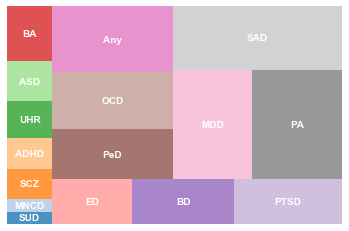

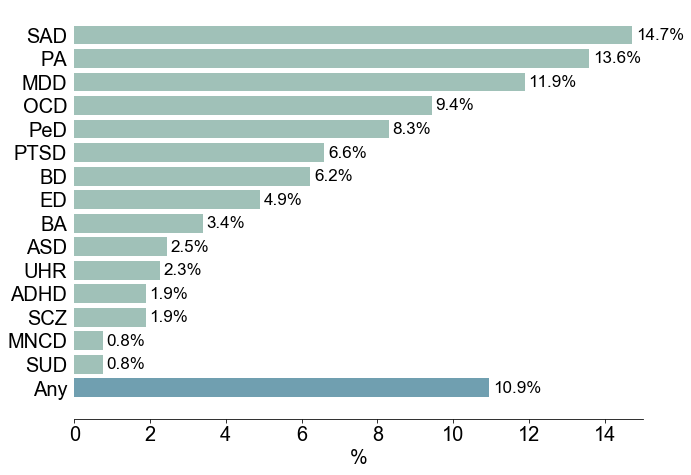

In [9]:


print(surv.columns[33])
disorders = surv[surv.columns[33]].dropna().reset_index(drop=True).copy()

disorders = disorders.apply(lambda x: [i.strip() for i in x.lower().split(",")]).explode().value_counts().reset_index().rename(columns={"index":"disorder","Per quali disturbi ritiene che l'uso di strumenti telematici sia più utile e vantaggioso?":"value"})

disorders["value"] = 100 * (disorders["value"]/disorders["value"].sum())

def dis(x):
    if x in ["disturbo d'ansia sociale"]:
        x="SAD"
    elif x in ["disturbo di panico"]:
        x="PA"
    elif x in ["disturbi depressivi"]:
        x="MDD"
    elif x in ["qualsiasi"]:
        x="Any"
    elif x in ["disturbo ossessivo-compulsivo e correlati"]:
        x="OCD"
    elif x in ["disturbi di personalità"]:
        x="PeD"
    elif x in ["disturbo post-traumatico da stress"]:
        x="PTSD"
    elif x in ["disturbi bipolari"]:
        x="BD"
    elif x in ["disturbi dell'alimentazione"]:
        x="ED"
    elif x in ["disturbi correlati a dipendenze comportamentali"]:
        x="BA"
    elif x in ["disturbi dello spettro dell'autismo"]:
        x="ASD"
    elif x in ["stati mentali a rischio di psicosi (uhr)"]:
        x="UHR"
    elif x in ["adhd"]:
        x="ADHD"
    elif x in ["schizofrenia e altri disturbi psicotici"]:
        x="SCZ"
    elif x in ["disturbi neurocognitivi maggiori"]:
        x="MNCD"
    elif x in ["disturbi correlati a sostanze"]:
        x="SUD"
    return x


disorders["disorder"] = disorders["disorder"].apply(dis)
disorders = disorders.sort_values(by="value").reset_index(drop=True)

squarify.plot(sizes=disorders['value'], label=disorders['disorder'], alpha=.8,color=sns.color_palette("tab20"),text_kwargs={'fontsize':10,"color":"white",'weight':'bold'})
plt.axis('off')
plt.show()

alld = disorders[disorders["disorder"]!="Any"].reset_index(drop=True)
anyd = disorders[disorders["disorder"]=="Any"].reset_index(drop=True)

fig,ax = plt.subplots(figsize=(10,7))
ax.barh(alld.disorder, alld.value, align='center',color="#a0c1b8")
ax.barh(-1, anyd.value, align='center',color="#709fb0")

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 3))

names = list(alld.disorder.values)
names.reverse()
names.extend(["Any"])
names.reverse()

ax.set_yticks(range(-1,len(names)-1))
ax.set_yticklabels(names)
ax.set_xlim((0,15))
ax.set_xlabel("%")
for i,r in alld.iterrows():
    plt.text(x =  r.value+.1, y = i-.2 , s = str(round(r.value,1))+'%' , size = 17, color="black")
plt.text(y =-1.2, x = anyd.value+.1 , s = str(round(anyd.value[0],1))+'%' , size = 17, color="black")
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    labelleft=True) # labels along the bottom edge are off
    
plt.tight_layout()

#fig.savefig(os.getcwd() + "\\figures\\figure_2\\disorders.tiff",dpi=600, bbox_inches = "tight")

In quali popolazioni ritiene che l'uso di strumenti telematici sia più utile e vantaggioso?


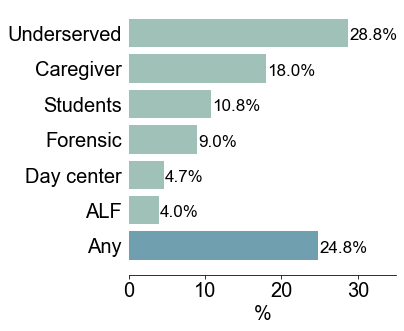

In [10]:

print(surv.columns[32])
pops = surv[surv.columns[32]].dropna().reset_index(drop=True).copy()
pops = pops.apply(lambda x: [i.strip() for i in x.lower().split(",")]).explode().value_counts().reset_index().rename(columns={"index":"popul","In quali popolazioni ritiene che l'uso di strumenti telematici sia più utile e vantaggioso?":"value"})
pops = pops[pops["value"]>1]

def pp(x):
    if x in ["pazienti che vivono in località difficilmente raggiungibili"]:
        x="Underserved"
    elif x in ["caregiver di pazienti con patologie croniche"]:
        x="Caregiver"
    elif x in ["studenti"]:
        x="Students"
    elif x in ["qualsiasi"]:
        x="Any"
    elif x in ["pazienti sottoposti a regime di custodia"]:
        x="Forensic"
    elif x in ["pazienti che frequentano i centri diurni"]:
        x="Day center"
    elif x in ["pazienti ricoverati in case di cura"]:
        x="ALF"
    
    return x

pops["popul"] = pops["popul"].apply(pp)
pops["value"] = 100 * ( pops["value"]/pops["value"].sum() )
pops = pops.sort_values(by="value").reset_index(drop=True)

alld = pops[pops["popul"]!="Any"].reset_index(drop=True)
anyd = pops[pops["popul"]=="Any"].reset_index(drop=True)

fig,ax = plt.subplots(figsize=(6,5))
ax.barh(alld.popul, alld.value, align='center',color="#a0c1b8")
ax.barh(-1, anyd.value, align='center',color="#709fb0")

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 3))

names = list(alld.popul.values)
names.reverse()
names.extend(["Any"])
names.reverse()

ax.set_yticks(range(-1,len(names)-1))
ax.set_yticklabels(names)
ax.set_xlim((0,35))
ax.set_xlabel("%")

for i,r in alld.iterrows():
    plt.text(x =  r.value+.1, y = i-.2 , s = str(round(r.value,1))+'%' , size = 17, color="black")
plt.text(y =-1.2, x = anyd.value+.1 , s = str(round(anyd.value[0],1))+'%' , size = 17, color="black")

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    labelleft=True) # labels along the bottom edge are off
    
    
plt.tight_layout()

#fig.savefig(os.getcwd() + "\\figures\\figure_2\\groups.tiff",dpi=600, bbox_inches = "tight")

0 L'impiego di strumenti telematici per la salute mentale è a un buon livello di implementazione in Italia
1 L'impiego di strumenti telematici per la salute mentale ha costi elevati
2 L'impiego di strumenti telematici per la salute mentale è un approccio valido, accurato ed efficace tanto quanto la pratica clinica in presenza
3 L'impiego di strumenti telematici per la salute mentale consente di stabilire una buona relazione medico-paziente
4 L'impiego di strumenti telematici per la salute mentale è vantaggioso in termini di tempo per l'operatore
5 L'impiego di strumenti telematici per la salute mentale è vantaggioso in termini di tempo per il paziente
6 L'impiego di strumenti telematici per la salute mentale presenta problemi di confidenzialità tali da limitarne l'utilizzo
7 L'impiego di strumenti telematici per la salute mentale permette di abbattere la barriera dello stigma
8 Ritengo di essere adeguatamente preparato all'impiego di strumenti telematici per la salute mentale
9 Sono gl

C:\Users\oldboy\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1350: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=layout_pad)


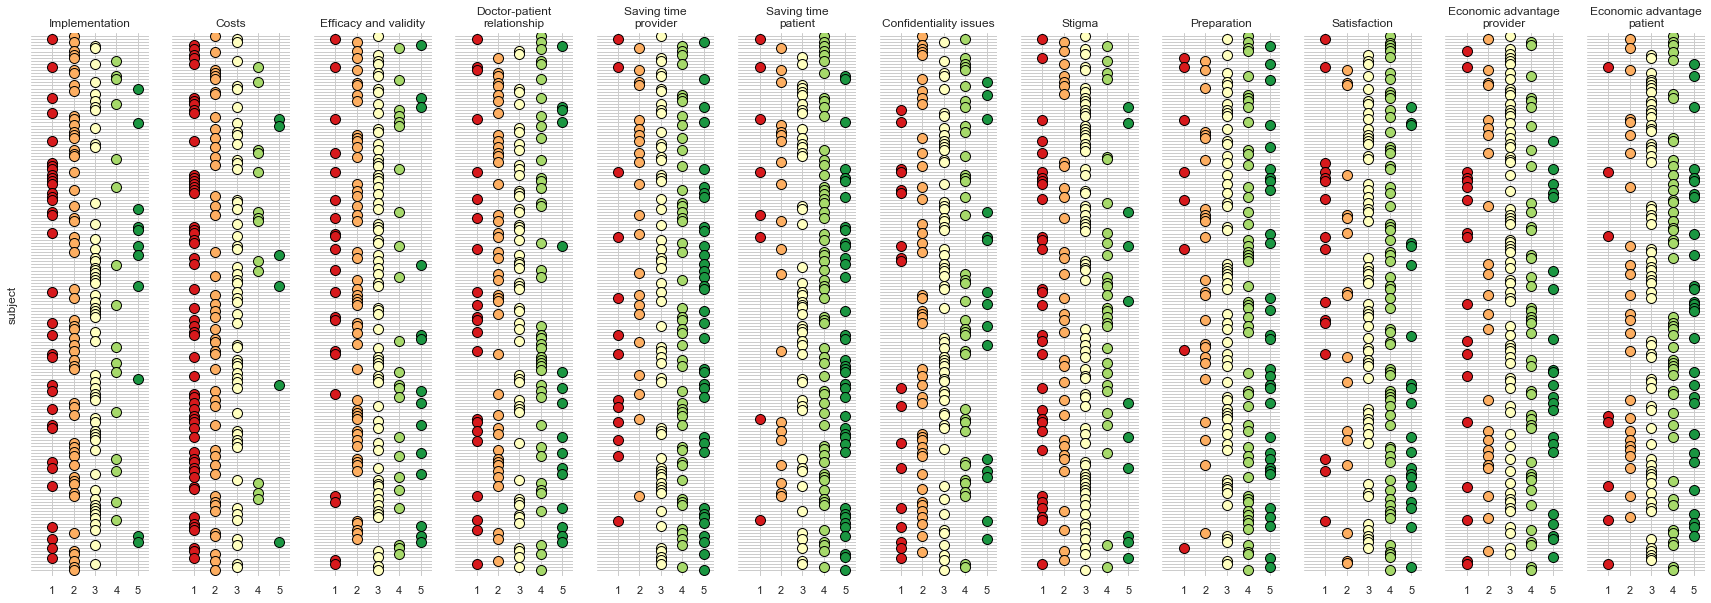

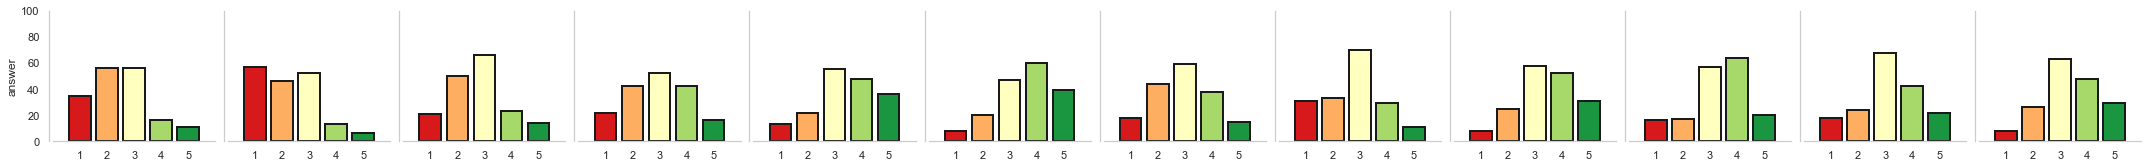

In [11]:

inds = [34,35,36,37,38,39,42,60,43,44,40,41]
for i,c in enumerate(surv.columns[inds]):
    print(i,c)

likert = surv.iloc[:,inds].dropna(axis=0,how="all").fillna(3) # 1 subject is all nan and 1 subject skipped one item [in this subject the answer is replaced with neutral 3]

likert = likert.reset_index().rename(columns= {"index":"subject"})

sns.set(style="whitegrid")

# Load the dataset
crashes = sns.load_dataset("car_crashes")

# Make the PairGrid
scr = sns.PairGrid(likert,
                 x_vars=likert.columns[1:], y_vars=["subject"],
                 height=10, aspect=.25,)


def mystrip(x,y, **kwargs):
    col = {1:'#d7191c',2:'#fdae61',3:'#ffffbf',4:'#a6d96a',5:'#1a9641'}
    sns.stripplot(x, y, edgecolor="black", palette=[col[i] for i in x], size=10, orient="h",
    linewidth=1)
    
# Draw a dot plot using the stripplot function
scr.map(mystrip)#color="purple")

scr.set(xlim=(0, 5.5), ylim=(len(likert)+1.1,-1.1,), xlabel="", xticks=[1,2,3,4,5],yticklabels=[])

# Use semantically meaningful titles for the columns
titles = ['Implementation','Costs',
          'Efficacy and validity',
          'Doctor-patient\nrelationship',
            'Saving time\nprovider',
          'Saving time\npatient', 
          'Confidentiality issues',
          'Stigma','Preparation',
          'Satisfaction', 
          'Economic advantage\nprovider',
          'Economic advantage\npatient' ]

for ax, title in zip(scr.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)


sns.despine(left=True, bottom=True)

plt.show()

likert = surv.iloc[:,inds].dropna(axis=0,how="all").fillna(3)
likert_f = likert.agg(pd.value_counts).fillna(0).reset_index().rename(columns={"index":"answer"})

hst = sns.PairGrid(likert_f,
                 x_vars=likert_f.columns[1:], y_vars=["answer"],aspect=1,)

def mybar(x,y, **kwargs):
    col = {1:'#d7191c',2:'#fdae61',3:'#ffffbf',4:'#a6d96a',5:'#1a9641'}
    plt.bar(y,x,color=['#d7191c','#fdae61','#ffffbf','#a6d96a','#1a9641'],edgecolor="k",linewidth=2)

for ax, title in zip(hst.axes.flat, titles):

    ax.spines['left'].set_position(('outward', 4))
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)

hst.map(mybar)
hst.set(xlim=(0, 6), ylim=(0,100),xlabel="",xticks=[1,2,3,4,5])

plt.tight_layout()

#scr.savefig(os.getcwd() + "\\figures\\figure_2\\scr_likert_ita.tiff",dpi=600, bbox_inches = "tight")
#hst.savefig(os.getcwd() + "\\figures\\figure_2\\hst_likert_ita.tiff",dpi=600, bbox_inches = "tight")